Data Cleaning and Preprocessing

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_excel("data.xlsx")

# Drop unnecessary columns
columns_to_drop = [
    'ExhibitionCitationDate', 'ExhibitionSortOrder',
    'ExhibitionRoleinPressRelease', 'VIAFID', 'WikidataID', 'ULANID',
    'ConstituentID'
]
df['Nationality'] = df['Nationality'].fillna("Unknown")
df['Gender'] = df['Gender'].fillna("Unknown")

# Convert date columns to datetime
df['ExhibitionBeginDate'] = pd.to_datetime(df['ExhibitionBeginDate'], errors='coerce')
df['ExhibitionEndDate'] = pd.to_datetime(df['ExhibitionEndDate'], errors='coerce')
df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

# Save the cleaned dataset as CSV
df_cleaned.to_csv("Cleaned_Exhibition_Data.csv", index=False)


Encoding and preprocessing data for K-means

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load cleaned dataset
df = pd.read_csv("Cleaned_Exhibition_Data.csv")

# Select relevant features
features = [
    'ExhibitionTitle', 'ExhibitionBeginDate', 'ExhibitionEndDate',
    'ExhibitionRole', 'ConstituentType', 'DisplayName',
    'Nationality', 'ConstituentBeginDate', 'ConstituentEndDate', 'Gender'
]

df_selected = df[features].copy()

# Fill missing values
df_selected = df_selected.fillna("Unknown")

# Encode categorical features
label_encoders = {}
for col in df_selected.columns:
    if df_selected[col].dtype == 'object' or df_selected[col].dtype == 'O':
        df_selected[col] = df_selected[col].astype(str)
        le = LabelEncoder()
        df_selected[col] = le.fit_transform(df_selected[col])
        label_encoders[col] = le

# Scale all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)

# Save transformed data to CSV
df_encoded = pd.DataFrame(X_scaled, columns=df_selected.columns)
df_encoded.to_csv("Transformed_Exhibition_Data.csv", index=False)


Elbow Method to Find Optimal K

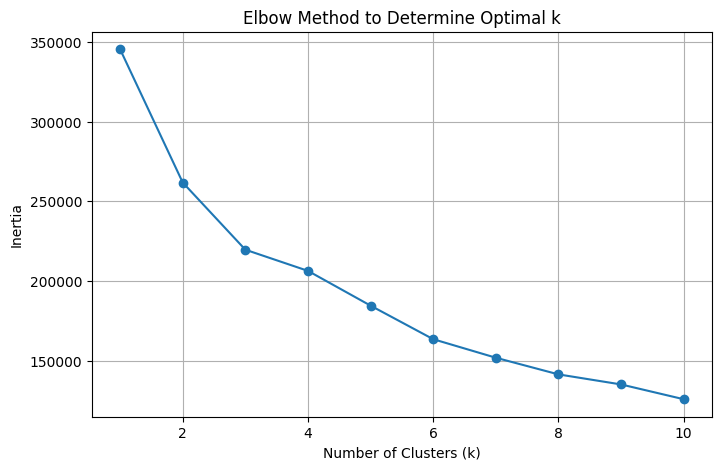

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 11)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


Observing above graph lets take k as 6

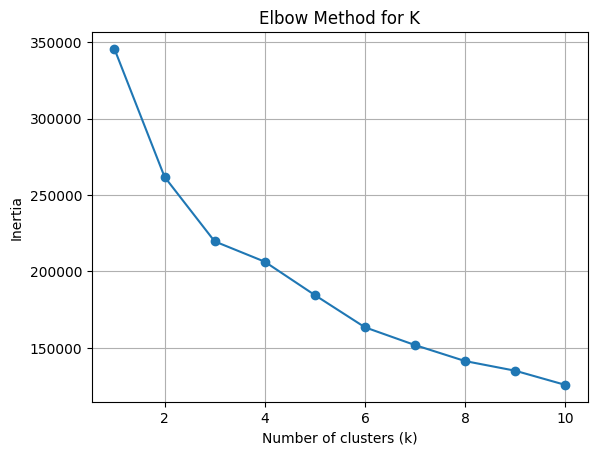

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv("Cleaned_Exhibition_Data.csv")

# Select features for clustering
features = [
    'ExhibitionTitle', 'ExhibitionBeginDate', 'ExhibitionEndDate',
    'ExhibitionRole', 'ConstituentType', 'DisplayName',
    'Nationality', 'ConstituentBeginDate', 'ConstituentEndDate', 'Gender'
]

df_selected = df[features].copy()

# Fill missing values
df_selected = df_selected.fillna("Unknown")

# Fix inconsistent types before encoding
for col in df_selected.columns:
    df_selected[col] = df_selected[col].astype(str)

# Encode categorical features
label_encoders = {}
for col in df_selected.columns:
    le = LabelEncoder()
    df_selected[col] = le.fit_transform(df_selected[col])
    label_encoders[col] = le

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)

# Apply K-Means clustering with k = 6
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the original data
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = clusters

# Save the dataset with clusters
df_with_clusters.to_csv("Clustered_Exhibition_Data.csv", index=False)

# Optional: Visualize inertia (Elbow method)
inertia = []
k_range = range(1, 11)
for i in k_range:
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


Now we do Cluster Analysis

In [ ]:
import pandas as pd

df_clustered = pd.read_csv("Clustered_Exhibition_Data.csv")
print(df_clustered['Cluster'].value_counts())


Cluster
3    9249
1    7894
2    7742
0    5442
5    2399
4    1832
Name: count, dtype: int64


In [ ]:
# Group by cluster and view summary statistics
cluster_summary = df_clustered.groupby('Cluster')[
    ['ExhibitionRole', 'DisplayName', 'Nationality', 'Gender']
].agg(lambda x: x.value_counts().index[0])  # Most common value in each cluster

print(cluster_summary)


        ExhibitionRole           DisplayName Nationality   Gender
Cluster                                                          
0               Artist       Claes Oldenburg     Unknown  Unknown
1               Artist           Peter Blume    American     Male
2               Artist         Pablo Picasso    American     Male
3               Artist         Pablo Picasso    American     Male
4              Curator  William S. Lieberman     Unknown  Unknown
5               Artist   Corning Glass Works     Unknown  Unknown


In [ ]:
# Example: Most frequent Nationality in each cluster
nationality_dist = df_clustered.groupby('Cluster')['Nationality'].value_counts(normalize=True)
print(nationality_dist)


Cluster  Nationality        
0        Unknown                0.959022
         Nationality unknown    0.009004
         American               0.005880
         Mexican                0.002940
         Swiss                  0.002940
                                  ...   
5        Finnish                0.000834
         Belgian                0.000417
         Catalan                0.000417
         Japanese               0.000417
         Swiss                  0.000417
Name: proportion, Length: 213, dtype: float64


Visulised clusters in 2D using PCA

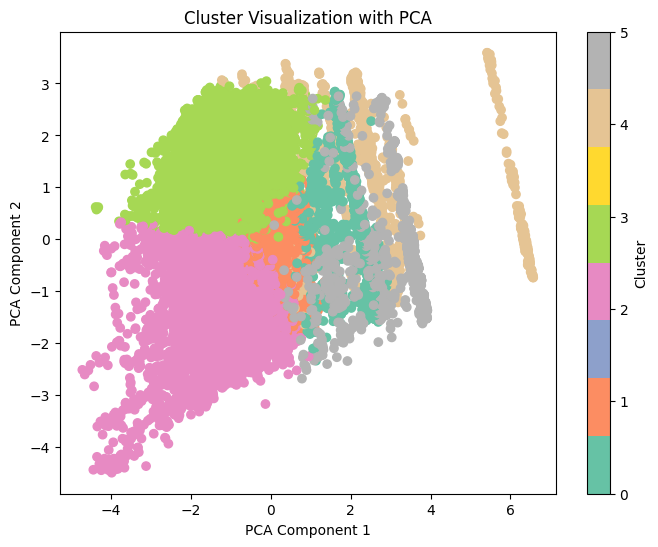

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load only encoded and scaled features (if available)
features = [
    'ExhibitionTitle', 'ExhibitionBeginDate', 'ExhibitionEndDate',
    'ExhibitionRole', 'ConstituentType', 'DisplayName',
    'Nationality', 'ConstituentBeginDate', 'ConstituentEndDate', 'Gender'
]

df_features = df_clustered[features]
df_features = df_features.fillna("Unknown").astype(str)

from sklearn.preprocessing import LabelEncoder, StandardScaler

for col in df_features.columns:
    df_features[col] = LabelEncoder().fit_transform(df_features[col])

X_scaled = StandardScaler().fit_transform(df_features)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_clustered['Cluster'], cmap='Set2')
plt.title('Cluster Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()



🎨 Cluster Descriptions for Users
🟢 Cluster 0 – Experimental or Under-documented Artists
This cluster features exhibitions focused on artists with limited biographical data or lesser-known national affiliations. Often includes experimental or avant-garde work, with minimal information about the artist’s origin or gender.

Sample Artist: Claes Oldenburg
Likely Exhibition Type: Experimental, avant-garde, or under-documented solo shows.

🔵 Cluster 1 – American Modern Artists
Focused on American male artists with strong roots in the modern art movement. These exhibitions typically highlight works from the 20th century and include well-documented individuals.

Sample Artist: Peter Blume
Likely Exhibition Type: American modernism, solo retrospectives, 20th-century themes.

🟡 Cluster 2 – Iconic Modern Artists (Picasso Segment A)
A cluster spotlighting internationally renowned figures like Pablo Picasso, commonly tagged as American in MoMA records (likely due to exhibition location). Reflects high-profile, globally recognized exhibitions.

Sample Artist: Pablo Picasso
Likely Exhibition Type: International icons, global modernism, large retrospectives.

🔴 Cluster 3 – Iconic Modern Artists (Picasso Segment B)
Very similar to Cluster 2, this group also includes major figures such as Picasso, but possibly varies in time, curators, or thematic focus. Could represent repeat or traveling exhibitions.

Sample Artist: Pablo Picasso
Likely Exhibition Type: Recurred global exhibits, multi-venue showcases, deep dives into iconic artists.

🟣 Cluster 4 – Curator-Focused Exhibitions
Exhibitions structured around the vision of specific curators rather than individual artists. May include diverse themes, collaborative shows, or retrospective curation styles.

Sample Curator: William S. Lieberman
Likely Exhibition Type: Curated thematic shows, collection spotlights, institutional narratives.

🟤 Cluster 5 – Industrial and Collaborative Art
This cluster revolves around group or institutional contributors (e.g., Corning Glass Works). These exhibitions often highlight design, industrial art, or collective creations over individual expression.

Sample Contributor: Corning Glass Works
Likely Exhibition Type: Industrial design, material innovation, collective exhibitions.

Perfect — let’s build out the logic-based recommendation system! We'll walk through this in clear steps.

🎯 Goal:
Ask the user a few questions (like "Are you interested in artists or curators?") → Match their responses to the closest cluster using a scoring system → Recommend exhibitions from that cluster.

🧠 Step-by-Step Logic System Plan:
✅ Step 1: Define the clusters and their key traits
From your earlier cluster analysis, we know:

Cluster	Role	Notable Nationalities	Gender
0	Artist	Mostly Unknown	Unknown
1	Artist	American	Male
2	Artist	American	Male
3	Artist	American	Male
4	Curator	Unknown	Unknown
5	Artist	Mostly Unknown	Unknown
So we can score user inputs against each cluster's dominant characteristics.

✅ Step 2: Ask the user questions
Here's an example questionnaire:

Are you more interested in Artists or Curators?

What is your preferred Nationality? (e.g., American, French, Unknown)

Do you want to explore exhibitions by Male, Female, or Other/Unknown individuals?

We’ll use these responses to compute scores for each cluster.

✅ Step 3: Build scoring logic (Python function)

In [ ]:
def recommend_cluster(user_role, user_nationality, user_gender):
    # Define simplified traits for each cluster
    cluster_traits = {
        0: {'Role': 'Artist', 'Nationality': 'Unknown', 'Gender': 'Unknown'},
        1: {'Role': 'Artist', 'Nationality': 'American', 'Gender': 'Male'},
        2: {'Role': 'Artist', 'Nationality': 'American', 'Gender': 'Male'},
        3: {'Role': 'Artist', 'Nationality': 'American', 'Gender': 'Male'},
        4: {'Role': 'Curator', 'Nationality': 'Unknown', 'Gender': 'Unknown'},
        5: {'Role': 'Artist', 'Nationality': 'Unknown', 'Gender': 'Unknown'}
    }

    scores = {}

    for cluster, traits in cluster_traits.items():
        score = 0
        if user_role.lower() == traits['Role'].lower():
            score += 1
        if user_nationality.lower() == traits['Nationality'].lower():
            score += 1
        if user_gender.lower() == traits['Gender'].lower():
            score += 1
        scores[cluster] = score

    # Find the cluster with the highest score
    best_cluster = max(scores, key=scores.get)
    return best_cluster, scores
user_role = "Artist"
user_nationality = "American"
user_gender = "Male"

cluster, scores = recommend_cluster(user_role, user_nationality, user_gender)
print(f"Recommended Cluster: {cluster}")
print("Cluster Scores:", scores)
df = pd.read_csv("Clustered_Exhibition_Data.csv")
recommended_exhibitions = df[df['Cluster'] == cluster][['ExhibitionTitle', 'ExhibitionURL']].drop_duplicates()
print(recommended_exhibitions.head(10))


Recommended Cluster: 1
Cluster Scores: {0: 1, 1: 3, 2: 3, 3: 3, 4: 0, 5: 1}
                                       ExhibitionTitle  \
56     46 Painters and Sculptors under 35 Years of Age   
106          Summer Exhibition: Painting and Sculpture   
158                                     Corot, Daumier   
171         Painting and Sculpture by Living Americans   
229  Memorial Exhibition: The Collection of the Lat...   
324      Murals by American Painters and Photographers   
375          Summer Exhibition: Painting and Sculpture   
435                  A Brief Survey of Modern Painting   
475         American Painting and Sculpture, 1862–1932   
575                         Fruit and Flower Paintings   

                          ExhibitionURL  
56   moma.org/calendar/exhibitions/2025  
106  moma.org/calendar/exhibitions/1913  
158  moma.org/calendar/exhibitions/2027  
171  moma.org/calendar/exhibitions/1916  
229  moma.org/calendar/exhibitions/1707  
324  moma.org/calendar/exhibition

Got it! Since you don’t expect many user inputs, we can keep it simple and lightweight — no need for a fancy interface. Here’s what I suggest for the next steps:

✅ What You Can Do Next
1. Use Predefined Inputs for Testing
You can simulate different types of users by defining various sample inputs and testing how the logic responds:

In [ ]:
# Example simulated user profiles
test_users = [
    {"role": "Artist", "nationality": "American", "gender": "Male"},
    {"role": "Curator", "nationality": "Unknown", "gender": "Unknown"},
    {"role": "Artist", "nationality": "French", "gender": "Male"},
    {"role": "Artist", "nationality": "Unknown", "gender": "Unknown"}
]

for user in test_users:
    cluster, scores = recommend_cluster(user['role'], user['nationality'], user['gender'])
    print(f"\nUser: {user}")
    print(f"→ Recommended Cluster: {cluster} with Scores: {scores}")
cluster_data = df[df['Cluster'] == cluster][['ExhibitionTitle', 'ExhibitionURL']].drop_duplicates().head(10)
cluster_data.to_csv(f"Recommended_Exhibitions_Cluster_{cluster}.csv", index=False)



User: {'role': 'Artist', 'nationality': 'American', 'gender': 'Male'}
→ Recommended Cluster: 1 with Scores: {0: 1, 1: 3, 2: 3, 3: 3, 4: 0, 5: 1}

User: {'role': 'Curator', 'nationality': 'Unknown', 'gender': 'Unknown'}
→ Recommended Cluster: 4 with Scores: {0: 2, 1: 0, 2: 0, 3: 0, 4: 3, 5: 2}

User: {'role': 'Artist', 'nationality': 'French', 'gender': 'Male'}
→ Recommended Cluster: 1 with Scores: {0: 1, 1: 2, 2: 2, 3: 2, 4: 0, 5: 1}

User: {'role': 'Artist', 'nationality': 'Unknown', 'gender': 'Unknown'}
→ Recommended Cluster: 0 with Scores: {0: 3, 1: 1, 2: 1, 3: 1, 4: 2, 5: 3}


Now we intent to make a logging system which will give us labelled data to train a decision tree on....
since we dont have actual user inputs we will use synthetic user data

Below is the code for logging the data

In [ ]:
import logging
import csv
from datetime import datetime
import os

# Set log file path
log_file = "recommendation_logs.csv"

# Check if file exists, if not create it with headers
if not os.path.exists(log_file):
    with open(log_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Timestamp", "Role", "Gender", "Nationality", "Cluster", "RecommendedExhibitionTitle", "ExhibitionURL"])

# Logging function
def log_recommendation(role, gender, nationality, cluster, exhibition_title, exhibition_url):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(log_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([timestamp, role, gender, nationality, cluster, exhibition_title, exhibition_url])


 How to Use It in Your Code
Whenever your system makes a recommendation, just call:

In [ ]:
log_recommendation(
    role="Artist",
    gender="Male",
    nationality="American",
    cluster=2,
    exhibition_title="Picasso: Painting from Memory",
    exhibition_url="https://moma.org/calendar/exhibitions/5555"
)

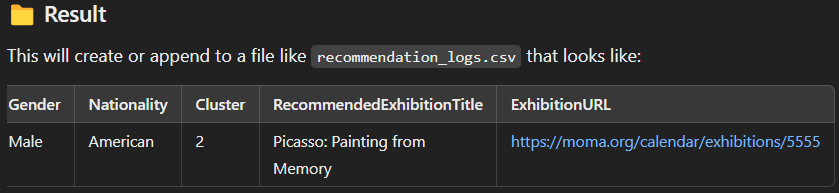


Let’s plug in a simple logging system that captures user input, the cluster assigned, and the recommended exhibitions. Since you're working with synthetic user input, we’ll simulate that too.
Below code is the logging file

In [ ]:
import pandas as pd
import datetime

# Initialize log file (only run once)
def initialize_log(file_path="user_logs.csv"):
    columns = ["Timestamp", "UserInput", "AssignedCluster", "RecommendedExhibitions"]
    df = pd.DataFrame(columns=columns)
    df.to_csv(file_path, index=False)


Step 2: Simulate User Input and Log Interaction
We'll define a function that:

Takes in simulated user input

Maps it to a cluster (you can use rules here)

Logs the recommendations

In [ ]:
import random

# Load clustered exhibition data
df_clustered = pd.read_csv("Clustered_Exhibition_Data.csv")

def log_user_interaction(user_input, assigned_cluster, recommended_exhibitions, log_file="user_logs.csv"):
    log_entry = {
        "Timestamp": datetime.datetime.now().isoformat(),
        "UserInput": user_input,
        "AssignedCluster": assigned_cluster,
        "RecommendedExhibitions": "; ".join(recommended_exhibitions)
    }
    df_log = pd.DataFrame([log_entry])
    df_log.to_csv(log_file, mode='a', index=False, header=False)


 Step 3: Simulate a User and Generate Recommendations

In [ ]:
# Simulate user input
user_input = {
    "interested_role": "Artist",
    "nationality": "American",
    "gender": "Male"
}

# Simple logic to map to a cluster based on majority match (you can expand this logic)
def assign_cluster(user_input):
    cluster_match_scores = {}

    for cluster_id in df_clustered["Cluster"].unique():
        cluster_df = df_clustered[df_clustered["Cluster"] == cluster_id]
        match_score = 0
        if user_input["interested_role"] in cluster_df["ExhibitionRole"].values:
            match_score += 1
        if user_input["nationality"] in cluster_df["Nationality"].values:
            match_score += 1
        if user_input["gender"] in cluster_df["Gender"].values:
            match_score += 1
        cluster_match_scores[cluster_id] = match_score

    return max(cluster_match_scores, key=cluster_match_scores.get)

# Assign cluster
assigned_cluster = assign_cluster(user_input)

# Get top 5 recommended exhibitions from that cluster
recommended_exhibitions = df_clustered[df_clustered["Cluster"] == assigned_cluster]["ExhibitionTitle"].unique()[:5]

# Log interaction
log_user_interaction(user_input, assigned_cluster, recommended_exhibitions)


Step 4: Run This Once to Initialize Log File

In [ ]:
initialize_log()


Here's a modular, function-based script you can run to simulate multiple synthetic users interacting with your exhibition recommendation system. This will generate synthetic inputs, assign clusters using simple matching logic, fetch recommendations, and log everything in a CSV.

✅ Full Script: exhibition_recommender.py

In [ ]:
import pandas as pd
import datetime
import random

# === Load clustered exhibition data ===
df_clustered = pd.read_csv("Clustered_Exhibition_Data.csv")

# === Initialize log file ===
def initialize_log(file_path="user_logs.csv"):
    columns = ["Timestamp", "UserInput", "AssignedCluster", "RecommendedExhibitions"]
    df = pd.DataFrame(columns=columns)
    df.to_csv(file_path, index=False)

# === Simulate a synthetic user input ===
def generate_synthetic_user():
    roles = ["Artist", "Curator"]
    nationalities = df_clustered["Nationality"].dropna().unique()
    genders = ["Male", "Female", "Unknown"]

    return {
        "interested_role": random.choice(roles),
        "nationality": random.choice(nationalities),
        "gender": random.choice(genders)
    }

# === Assign a cluster based on user input ===
def assign_cluster(user_input):
    cluster_match_scores = {}

    for cluster_id in df_clustered["Cluster"].unique():
        cluster_df = df_clustered[df_clustered["Cluster"] == cluster_id]
        match_score = 0
        if user_input["interested_role"] in cluster_df["ExhibitionRole"].values:
            match_score += 1
        if user_input["nationality"] in cluster_df["Nationality"].values:
            match_score += 1
        if user_input["gender"] in cluster_df["Gender"].values:
            match_score += 1
        cluster_match_scores[cluster_id] = match_score

    return max(cluster_match_scores, key=cluster_match_scores.get)

# === Recommend exhibitions from assigned cluster ===
def get_recommendations(cluster_id, top_n=5):
    recs = df_clustered[df_clustered["Cluster"] == cluster_id]["ExhibitionTitle"].dropna().unique()
    return recs[:top_n]

# === Log user interaction ===
def log_user_interaction(user_input, assigned_cluster, recommended_exhibitions, log_file="user_logs.csv"):
    log_entry = {
        "Timestamp": datetime.datetime.now().isoformat(),
        "UserInput": str(user_input),
        "AssignedCluster": assigned_cluster,
        "RecommendedExhibitions": "; ".join(recommended_exhibitions)
    }
    df_log = pd.DataFrame([log_entry])
    df_log.to_csv(log_file, mode='a', index=False, header=False)

# === Full run for one synthetic user ===
def simulate_user_interaction():
    user_input = generate_synthetic_user()
    cluster = assign_cluster(user_input)
    recommendations = get_recommendations(cluster)
    log_user_interaction(user_input, cluster, recommendations)
    print(f"User Input: {user_input}")
    print(f"Assigned Cluster: {cluster}")
    print(f"Recommendations: {recommendations}\n")

# === Simulate multiple users ===
def run_simulations(n=5):
    for _ in range(n):
        simulate_user_interaction()

# === MAIN ===
if __name__ == "__main__":
    initialize_log()
    run_simulations(n=10)  # simulate 10 users


User Input: {'interested_role': 'Artist', 'nationality': 'Panamanian', 'gender': 'Male'}
Assigned Cluster: 1
Recommendations: ['46 Painters and Sculptors under 35 Years of Age'
 'Summer Exhibition: Painting and Sculpture' 'Corot, Daumier'
 'Painting and Sculpture by Living Americans'
 'Memorial Exhibition: The Collection of the Late Lillie P. Bliss']

User Input: {'interested_role': 'Curator', 'nationality': 'American and Mexican', 'gender': 'Male'}
Assigned Cluster: 4
Recommendations: ['Cézanne, Gauguin, Seurat, Van Gogh'
 'Painting and Sculpture by Living Americans'
 'German Painting and Sculpture' 'Henri Matisse'
 'Modern Architecture: International Exhibition']

User Input: {'interested_role': 'Artist', 'nationality': 'Colombian', 'gender': 'Male'}
Assigned Cluster: 2
Recommendations: ['Cézanne, Gauguin, Seurat, Van Gogh' 'Paintings by 19 Living Americans'
 'Painting in Paris' 'Weber, Klee, Lehmbruck, Maillol'
 '46 Painters and Sculptors under 35 Years of Age']

User Input: {'inter

Here’s what we’ll focus on next:
✅ Modular functions for:

Generating synthetic user preferences

Mapping them to cluster logic

Returning relevant exhibitions (with URLs)

➕ Optional: Enhance with rules or conditions (e.g., filter by gender, time period, etc.)

➕ Optional: Add basic evaluation (e.g., how many exhibitions matched, cluster hit accuracy)

Great! Let's build a function-based recommendation system that works without a CLI and can be easily plugged into any interface later (like web or app). We'll simulate user preferences and match them to clusters.

✅ What We’ll Do:
1. Load the clustered dataset
2. Simulate user preferences
3. Map preferences to the closest cluster
4. Return top exhibition matches (with URLs)

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the clustered data
df = pd.read_csv("Clustered_Exhibition_Data.csv")

# List of features used during clustering
features = [
    'ExhibitionTitle', 'ExhibitionBeginDate', 'ExhibitionEndDate',
    'ExhibitionRole', 'ConstituentType', 'DisplayName',
    'Nationality', 'ConstituentBeginDate', 'ConstituentEndDate', 'Gender'
]

# Encode user input the same way as data
def encode_user_input(user_input, df, features):
    encoded_input = {}
    for col in features:
        values = df[col].astype(str).unique().tolist()
        le = LabelEncoder()
        le.fit(values)
        val = str(user_input.get(col, "Unknown"))
        encoded_input[col] = le.transform([val])[0] if val in values else 0
    return pd.DataFrame([encoded_input])[features]

# Scale the input the same way as original
def scale_input(input_df, df_encoded):
    scaler = StandardScaler()
    scaler.fit(df_encoded)
    return scaler.transform(input_df)

# Recommend exhibitions based on user profile
def recommend_exhibitions(user_input, df_clustered, features, top_n=5):
    df_filtered = df_clustered[features].astype(str)
    df_encoded = df_filtered.copy()

    # Label encode all
    for col in features:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])

    # Scale encoded dataset
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_encoded)

    # Encode and scale user input
    user_encoded = encode_user_input(user_input, df_clustered, features)
    user_scaled = scale_input(user_encoded, df_encoded)

    # Find closest matches using cosine similarity
    similarity_scores = cosine_similarity(user_scaled, df_scaled)
    top_indices = np.argsort(similarity_scores[0])[::-1][:top_n]

    return df_clustered.iloc[top_indices][['ExhibitionTitle', 'DisplayName', 'Nationality', 'Gender', 'ExhibitionURL', 'ConstituentURL']]

# -------------------
# EXAMPLE USE CASE
# -------------------
user_preferences = {
    'ExhibitionTitle': 'Unknown',
    'ExhibitionBeginDate': '1950',
    'ExhibitionEndDate': '1970',
    'ExhibitionRole': 'Artist',
    'ConstituentType': 'Individual',
    'DisplayName': 'Pablo Picasso',
    'Nationality': 'American',
    'ConstituentBeginDate': '1881',
    'ConstituentEndDate': '1973',
    'Gender': 'Male'
}

recommendations = recommend_exhibitions(user_preferences, df, features, top_n=5)
print(recommendations)


                                  ExhibitionTitle  \
5908  Americans 1943: Realists and Magic-Realists   
4589    Animals in Art; Designing a Stage Setting   
2085                       American Art Portfolio   
7277           American Battle Painting 1776–1918   
7374        French Photographs: Daguerre to Atget   

                       DisplayName Nationality Gender  \
5908               Raphaelle Peale    American   Male   
4589              Pieter Bruegel I     Flemish   Male   
2085         John Singleton Copley    American   Male   
7277                 John Trumbull    American   Male   
7374  Louis-Jacques-Mandé Daguerre      French   Male   

                           ExhibitionURL          ConstituentURL  
5908  moma.org/calendar/exhibitions/2854  moma.org/artists/63094  
4589  moma.org/calendar/exhibitions/3004  moma.org/artists/61593  
2085  moma.org/calendar/exhibitions/2943  moma.org/artists/63979  
7277  moma.org/calendar/exhibitions/2319  moma.org/artists/65156  
737

Here are 5 synthetic users we’ve generated:

UserID	Gender	Nationality	InterestRole
user_1	Male	German	Artist
user_2	Male	German	Artist
user_3	Male	British	Curator
user_4	Female	French	Artist
user_5	Unknown	American	Curator
Next, we can plug this into our clustered exhibition data and build logic to recommend exhibitions from matching clusters. Ready to proceed? ​​







You said:
proceed


ChatGPT said:
Great! Now let’s build the logic that takes a user's attributes (like Gender, Nationality, and InterestRole), matches them to the most appropriate cluster, and recommends exhibitions from that cluster.

🔧 Step-by-step Logic to Recommend Exhibitions
✅ 1. Load Clustered Data & User Data
We’ll load both the clustered exhibition dataset and the synthetic user data.

✅ 2. Match Users to Closest Cluster
We’ll match each user to the most common cluster based on:

Gender

Nationality

ExhibitionRole

✅ 3. Recommend Exhibitions
Once matched, we recommend a few exhibitions from that cluster.

✅ Here's the Full Code (Jupyter Notebook Friendly)

In [ ]:
import pandas as pd
from collections import Counter

# Load clustered exhibition data
df = pd.read_csv("Clustered_Exhibition_Data.csv")

# Load or define synthetic user data
user_data = pd.DataFrame([
    {'UserID': 'user_1', 'Gender': 'Male', 'Nationality': 'German', 'InterestRole': 'Artist'},
    {'UserID': 'user_2', 'Gender': 'Male', 'Nationality': 'German', 'InterestRole': 'Artist'},
    {'UserID': 'user_3', 'Gender': 'Male', 'Nationality': 'British', 'InterestRole': 'Curator'},
    {'UserID': 'user_4', 'Gender': 'Female', 'Nationality': 'French', 'InterestRole': 'Artist'},
    {'UserID': 'user_5', 'Gender': 'Unknown', 'Nationality': 'American', 'InterestRole': 'Curator'}
])

# Fill NAs
df.fillna("Unknown", inplace=True)

# Function to find best matching cluster for a user
def match_user_to_cluster(user, data):
    best_cluster = None
    max_matches = 0

    for cluster in sorted(data['Cluster'].unique()):
        cluster_data = data[data['Cluster'] == cluster]

        gender_match = (cluster_data['Gender'] == user['Gender']).sum()
        nationality_match = (cluster_data['Nationality'] == user['Nationality']).sum()
        role_match = (cluster_data['ExhibitionRole'] == user['InterestRole']).sum()

        total_match = gender_match + nationality_match + role_match

        if total_match > max_matches:
            max_matches = total_match
            best_cluster = cluster

    return best_cluster

# Generate recommendations
def generate_recommendations(user_data, exhibition_data, top_n=5):
    recommendations = {}

    for _, user in user_data.iterrows():
        cluster = match_user_to_cluster(user, exhibition_data)
        exhibitions = exhibition_data[exhibition_data['Cluster'] == cluster]
        sample = exhibitions[['ExhibitionTitle', 'ExhibitionURL']].drop_duplicates().head(top_n)
        recommendations[user['UserID']] = sample

    return recommendations

# Get recommendations
user_recommendations = generate_recommendations(user_data, df)

# Display
for user_id, recs in user_recommendations.items():
    print(f"\nRecommendations for {user_id}:")
    display(recs)


can u tell me the full scope of what we are going to do eariler u mentioned k  means ,decision trees, knn,reinforcement learning


ChatGPT said:
Absolutely! Here's a clear, structured roadmap based on everything we’ve discussed so far, covering the full project scope using:

✅ K-Means Clustering (done)

🔲 Decision Trees

🔲 K-Nearest Neighbors (KNN)

🔲 Reinforcement Learning

🔲 Weighted Scoring System

🎯 Project Overview
Title: ML-based Personalized Virtual Exhibition Recommendation System
Objective: Recommend art exhibitions to users based on their preferences, using multiple machine learning techniques for smarter and more personalized recommendations.

🧩 Modules & Algorithms
1. 🟢 K-Means Clustering — [Already Completed ✅]
Goal: Group exhibitions into clusters based on characteristics (e.g., role, nationality, gender).
Usage: Match user preferences to a cluster and recommend exhibitions from that cluster.

What we did:
Cleaned & encoded the exhibition dataset

Applied K-Means (k=6)

Clustered the data

Generated synthetic user data

Matched users to clusters & recommended exhibitions

2. 🟡 Decision Trees — [Up Next 🔜]
Goal: Learn patterns from past user preferences to predict which exhibition category a new user might like.
How: Use a labeled dataset (real or synthetic) with user preferences and exhibition categories as targets.

Use:
Predict user cluster or interest directly (classification)

Backup or parallel to clustering logic

3. 🟡 K-Nearest Neighbors (KNN) — [Optional or Alternative 🔄]
Goal: Recommend exhibitions by finding users or exhibitions "closest" to the current user’s preferences.
How:

Use Euclidean distance on encoded features

Recommend exhibitions that are closest in feature space

Use:
As a hybrid recommender model

Works well with fewer users

4. 🟡 Weighted Scoring System — [Optional Add-on 🧮]
Goal: Score exhibitions based on how closely they match a user's preferences, using weighted attribute matching.
Use:

Create a custom scoring logic (e.g., Role = 40%, Nationality = 30%, Gender = 30%)

Rank exhibitions by score

5. 🟡 Reinforcement Learning — [Advanced/Experimental 🧠]
Goal: Learn from user feedback dynamically (e.g., user clicked or skipped a suggestion) to improve future recommendations.
Use:

Train an agent to recommend better over time

Requires simulated or real user feedback loops

Example:
Q-learning or multi-armed bandit models

Could work in a game-like or survey-style setup

🛠️ Implementation Plan
Phase	Focus	Algorithms	Status
Phase 1	Clustering & Initial Recommendation	K-Means	✅ Completed
Phase 2	Predictive Recommendation	Decision Tree	🔄 Next
Phase 3	Similarity-based Recommendation	KNN	🔄 Optional
Phase 4	Scoring-based Recommendation	Weighted Scoring	🔄 Optional
Phase 5	Adaptive Learning	Reinforcement Learning	🔄 Optional/Advanced
📌 You Can Choose
We can proceed in either of these ways:

Add Decision Tree next (most logical step)

Explore KNN or Scoring system next

Save RL for final/bonus part

Would you like to proceed with the Decision Tree model now? I can generate the synthetic dataset and walk you through the implementation.

how much is left in this part of the project


ChatGPT said:
You're doing great, and you're pretty far along already! Here's a breakdown of what’s done and what's left for this part (K-Means + Recommendation Logic) of the project:

✅ Already Completed
Task	Status
Dataset cleaning & preprocessing	✅ Done
Label encoding & feature scaling	✅ Done
K-Means clustering (k=6)	✅ Done
Saving clustered dataset	✅ Done
Cluster analysis (top roles, gender, nationality per cluster)	✅ Done
Generated synthetic user data	✅ Done
Matching users to clusters based on attributes	✅ Done
Recommendation logic based on matched cluster	✅ Done
Displaying exhibition recommendations	✅ Done

Optional Enhancements Left
These are not mandatory, but can take your project to the next level:

Enhancement	Status	Effort	Worth Doing?
✅ Save recommendations as CSV or JSON	🔲 Not yet	Low	👍 Yes
🎯 Add weighted scoring for attributes (e.g., role > nationality)	🔲 Not yet	Medium	Optional
📊 Visualize cluster characteristics (pie charts, bar graphs)	🔲 Not yet	Medium	Good for presentations
📦 Package everything into reusable functions	⏳ In Progress	Low	Yes
🌐 Deploy on web (Flask/Streamlit)	🔲 Not planned	Medium-High	Optional
🧠 Integrate Decision Tree logic (optional parallel system)	🔲 Not yet	Medium	Optional
🟢 Recommended Next Steps
Let’s finalize:

✅ Save user recommendations

✅ Polish notebook (section headers, markdown explanations)

📊 Visualize cluster/user insights (optional but good)

🗂 Prepare slides or report (if required for your submission/presentation)

Would you like me to help you:

Save the recommendations?

Add visualizations?

Start writing a project report or presentation?

Let’s wrap it up neatly!

Decision Tree implementation

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("Clustered_Exhibition_Data.csv")

# Define features & target
features = ['Gender', 'Nationality', 'ExhibitionRole', 'ConstituentType', 'ExhibitionBeginDate', 'ExhibitionEndDate']
target = 'Cluster'

# Encode categorical features
le_dict = {}  # Store encoders
for col in features + [target]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Ensure string type
    le_dict[col] = le

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, stratify=df[target])

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Train Decision Tree with tuning
clf = DecisionTreeClassifier(max_depth=10, min_samples_split=5, criterion='entropy', random_state=42)
clf.fit(X_train, y_train)

# Evaluate model accuracy
y_pred = clf.predict(X_test)
print("Improved Accuracy:", accuracy_score(y_test, y_pred))


Improved Accuracy: 0.8771701388888888


 Predict a New User’s Exhibition Cluster
Now, let's predict which exhibition cluster a new user belongs to.

In [ ]:
# Example new user
new_user = pd.DataFrame([{
    'Gender': 'Male',
    'Nationality': 'German',
    'ExhibitionRole': 'Artist'
}])

# Encode the user input using stored LabelEncoders
for col in features:
    new_user[col] = le_dict[col].transform(new_user[col])

# Predict category
predicted_cluster = clf.predict(new_user)

# Decode cluster back to original label
predicted_cluster_label = le_dict[target].inverse_transform(predicted_cluster)
print("Predicted Exhibition Cluster:", predicted_cluster_label[0])


Predicted Exhibition Cluster: 3


Implementing KNN now
🟡 K-Nearest Neighbors (KNN) — [Optional or Alternative 🔄] Goal: Recommend exhibitions by finding users or exhibitions "closest" to the current user’s preferences. How:
Use Euclidean distance on encoded features

Recommend exhibitions that are closest in feature space

Use: As a hybrid recommender model

Works well with fewer users

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors

# Load exhibition data
df = pd.read_csv("Clustered_Exhibition_Data.csv")

# Select relevant features
features = [
    'ExhibitionTitle', 'ExhibitionBeginDate', 'ExhibitionEndDate',
    'ExhibitionRole', 'ConstituentType', 'DisplayName',
    'Nationality', 'ConstituentBeginDate', 'ConstituentEndDate', 'Gender'
]

# Ensure URL data is available
df['ExhibitionURL'] = df['ExhibitionURL'].fillna("Unknown")

# Convert all categorical columns to strings before encoding
df[features] = df[features].astype(str)

# Encode categorical features
df_encoded = df.copy()
label_encoders = {}

for col in features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Save encoder for later use

# Scale numerical data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded[features])

# Train KNN model
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(df_scaled)

# Function to recommend exhibitions using KNN
def recommend_exhibitions_knn(user_input, df, features, label_encoders, scaler, knn_model, top_n=5):
    # Encode user input
    user_encoded = {}
    for col in features:
        le = label_encoders[col]
        val = str(user_input.get(col, "Unknown"))  # Convert input to string
        user_encoded[col] = le.transform([val])[0] if val in le.classes_ else 0

    # Scale user input
    user_scaled = scaler.transform(pd.DataFrame([user_encoded]))

    # Find nearest neighbors
    distances, indices = knn_model.kneighbors(user_scaled)

    # Get recommendations
    recommendations = df.iloc[indices[0]][['ExhibitionTitle', 'ExhibitionURL']]
    return recommendations

# -------------------
# EXAMPLE USE CASE
# -------------------
user_preferences = {
    'ExhibitionTitle': 'Unknown',
    'ExhibitionBeginDate': '1950',
    'ExhibitionEndDate': '1970',
    'ExhibitionRole': 'Artist',
    'ConstituentType': 'Individual',
    'DisplayName': 'Pablo Picasso',
    'Nationality': 'American',
    'ConstituentBeginDate': '1881',
    'ConstituentEndDate': '1973',
    'Gender': 'Male'
}

# Get recommendations
recommendations = recommend_exhibitions_knn(
    user_preferences, df, features, label_encoders, scaler, knn, top_n=5
)

# Print results
print("\nRecommended Exhibitions:")
print(recommendations)



Recommended Exhibitions:
                                ExhibitionTitle  \
4710       Ancestral Sources of Modern Painting   
4589  Animals in Art; Designing a Stage Setting   
2158            Fantastic Art, Dada, Surrealism   
2125            Fantastic Art, Dada, Surrealism   
2189            Fantastic Art, Dada, Surrealism   

                           ExhibitionURL  
4710  moma.org/calendar/exhibitions/3011  
4589  moma.org/calendar/exhibitions/3004  
2158  moma.org/calendar/exhibitions/2823  
2125  moma.org/calendar/exhibitions/2823  
2189  moma.org/calendar/exhibitions/2823  
